# 🤖 ETAPA 2: Machine Learning - Clasificación de Sentimientos

**Proyecto:** Sistema de Análisis de Sentimiento - Amazon Reviews  
**Curso:** Data Science III - NLP & Deep Learning  
**Autor:** Miguel  
**Fecha:** Enero 2026

---

## 📋 Objetivos de este Notebook (ETAPA 2 - Parte 1)

Aplicar técnicas de Machine Learning para clasificar sentimientos:

### Vectorización:
1. ✅ TF-IDF (Term Frequency-Inverse Document Frequency)
2. ✅ Bag of Words (CountVectorizer)

### Modelos:
3. ✅ Regresión Logística
4. ✅ Naive Bayes
5. ✅ Random Forest
6. ✅ Support Vector Machine (SVM)

### Evaluación:
7. ✅ Métricas completas
8. ✅ Comparación de modelos
9. ✅ Optimización de hiperparámetros

---

## 1. Setup e Imports

In [28]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# System
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Imports locales
sys.path.append('../')
from config import *
from src.data_loader import *

print("✅ Imports completados exitosamente")

✅ Imports completados exitosamente


In [29]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Configuración lista")

✅ Configuración lista


## 2. Cargar Datos Procesados

In [30]:
# Cargar datos con NLP aplicado
df = load_processed_data(filename='reviews_nlp_processed.csv')

print(f"\n📊 Dataset cargado:")
print(f"   - Filas: {len(df):,}")
print(f"   - Columnas: {df.columns.tolist()}")
print(f"   - Positivos: {(df['Sentiment']==1).sum():,} ({(df['Sentiment']==1).sum()/len(df)*100:.1f}%)")
print(f"   - Negativos: {(df['Sentiment']==0).sum():,} ({(df['Sentiment']==0).sum()/len(df)*100:.1f}%)")

📂 Cargando datos procesados desde: c:\Users\maike\OneDrive\Escritorio\Proyecto Datascience 3\notebooks\..\data\processed\reviews_nlp_processed.csv
✅ Datos cargados: 363,830 filas

📊 Dataset cargado:
   - Filas: 363,830
   - Columnas: ['Text', 'Text_Processed', 'Summary', 'Score', 'Sentiment', 'Text_Length', 'Word_Count', 'VADER_Compound', 'VADER_Positive', 'VADER_Negative', 'VADER_Neutral']
   - Positivos: 306,760 (84.3%)
   - Negativos: 57,070 (15.7%)


In [31]:
# Ver primeras filas
df.head()

,Text,Text_Processed,Summary,Score,Sentiment,Text_Length,Word_Count,VADER_Compound,VADER_Positive,VADER_Negative,VADER_Neutral
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,Good Quality Dog Food,5,1,263,48,0.9441,0.289,0.000,0.711
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,Not as Advertised,1,0,190,31,-0.5664,0.000,0.138,0.862
2,This is a confection that has been around a fe...,confection around century light pillowy citrus...,"""Delight"" says it all",4,1,509,94,0.8138,0.144,0.085,0.771
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,Cough Medicine,2,0,219,41,0.4404,0.068,0.000,0.932
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,Great taffy,5,1,140,27,0.9468,0.401,0.000,0.599


## 3. Preparación de Datos

### Train-Test Split

In [32]:
# Separar features (X) y target (y)
X = df['Text_Processed']  # Texto procesado de la ETAPA 1
y = df['Sentiment']       # 0 = Negativo, 1 = Positivo

print(f"📊 Variables:")
print(f"   X (features): {X.shape}")
print(f"   y (target): {y.shape}")
print(f"\n   Distribución de y:")
print(y.value_counts())

📊 Variables:
   X (features): (363830,)
   y (target): (363830,)

   Distribución de y:
Sentiment
1    306760
0     57070
Name: count, dtype: int64


In [33]:
# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Mantener proporción de clases
)

print(f"\n✅ Train-Test Split completado:")
print(f"   Train: {len(X_train):,} samples")
print(f"   Test:  {len(X_test):,} samples")
print(f"\n   Distribución Train: {y_train.value_counts().to_dict()}")
print(f"   Distribución Test:  {y_test.value_counts().to_dict()}")


✅ Train-Test Split completado:
   Train: 291,064 samples
   Test:  72,766 samples

   Distribución Train: {1: 245408, 0: 45656}
   Distribución Test:  {1: 61352, 0: 11414}


## 4. Vectorización: TF-IDF

### ¿Qué es TF-IDF?
- **TF (Term Frequency):** Frecuencia de una palabra en un documento
- **IDF (Inverse Document Frequency):** Importancia de la palabra en todo el corpus
- **TF-IDF = TF × IDF:** Da más peso a palabras importantes y menos a palabras comunes

In [34]:
# Crear vectorizador TF-IDF
print("🔄 Creando vectorizador TF-IDF...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,     # Top 5000 palabras más importantes
    min_df=5,              # Palabra debe aparecer en al menos 5 documentos
    max_df=0.8,            # Palabra no debe aparecer en más del 80% de documentos
    ngram_range=(1, 2)     # Unigramas y bigramas
)

print("✅ Vectorizador TF-IDF creado")

🔄 Creando vectorizador TF-IDF...
✅ Vectorizador TF-IDF creado


In [35]:
# Aplicar TF-IDF (CON LIMPIEZA DE NaN)
print("🔄 Aplicando TF-IDF...")

X_train_clean = X_train.fillna('').astype(str)
X_test_clean = X_test.fillna('').astype(str)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

print(f"\n✅ TF-IDF aplicado:")
print(f"   X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"   X_test_tfidf shape:  {X_test_tfidf.shape}")
print(f"   Vocabulario: {len(tfidf_vectorizer.vocabulary_)} palabras")

🔄 Aplicando TF-IDF...

✅ TF-IDF aplicado:
   X_train_tfidf shape: (291064, 5000)
   X_test_tfidf shape:  (72766, 5000)
   Vocabulario: 5000 palabras


In [36]:
# Ver las palabras más importantes
feature_names = tfidf_vectorizer.get_feature_names_out()

print("📋 Primeras 20 features (palabras/bigramas):")
print(feature_names[:20])

print("\n📋 Últimas 20 features:")
print(feature_names[-20:])

📋 Primeras 20 features (palabras/bigramas):
['10' '10 minute' '10 year' '100' '100 calorie' '1000' '11' '110' '12'
 '12 cup' '12 oz' '12 pack' '12 year' '120' '13' '130' '14' '14 cup' '140'
 '15']

📋 Últimas 20 features:
['yes' 'yesterday' 'yet' 'yogi' 'yogurt' 'york' 'young' 'younger' 'yr'
 'yr old' 'yuck' 'yum' 'yum yum' 'yummy' 'zero' 'zevia' 'zico' 'zing'
 'zip' 'ziplock']


## 5. Vectorización: Bag of Words (BOW)

### ¿Qué es BOW?
- Cuenta cuántas veces aparece cada palabra
- Más simple que TF-IDF
- Útil para comparar con TF-IDF

In [37]:
# Crear vectorizador BOW
print("🔄 Creando vectorizador BOW...")

bow_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)
)

# Aplicar BOW
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"\n✅ BOW aplicado:")
print(f"   X_train_bow shape: {X_train_bow.shape}")
print(f"   X_test_bow shape:  {X_test_bow.shape}")

🔄 Creando vectorizador BOW...

✅ BOW aplicado:
   X_train_bow shape: (291064, 5000)
   X_test_bow shape:  (72766, 5000)


## 6. Modelo 1: Regresión Logística + TF-IDF

### ¿Por qué Regresión Logística?
- Recomendado por el profesor
- Rápido y efectivo para clasificación de texto
- Interpretable (podemos ver qué palabras influyen más)

In [38]:
# Entrenar Regresión Logística con TF-IDF
print("🔄 Entrenando Regresión Logística + TF-IDF...")

lr_tfidf = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1  # Usar todos los cores disponibles
)

lr_tfidf.fit(X_train_tfidf, y_train)

print("✅ Modelo entrenado")

🔄 Entrenando Regresión Logística + TF-IDF...
✅ Modelo entrenado


In [39]:
# Predecir
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
y_pred_proba_lr_tfidf = lr_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Métricas
print("📊 REGRESIÓN LOGÍSTICA + TF-IDF:")
print("="*80)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr_tfidf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr_tfidf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr_tfidf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr_tfidf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr_tfidf):.4f}")
print("="*80)

📊 REGRESIÓN LOGÍSTICA + TF-IDF:
Accuracy:  0.9263
Precision: 0.9395
Recall:    0.9754
F1-Score:  0.9571
ROC-AUC:   0.9568


In [40]:
# Classification Report
print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_lr_tfidf, 
                          target_names=['Negativo', 'Positivo']))


📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Negativo       0.83      0.66      0.74     11414
    Positivo       0.94      0.98      0.96     61352

    accuracy                           0.93     72766
   macro avg       0.89      0.82      0.85     72766
weighted avg       0.92      0.93      0.92     72766



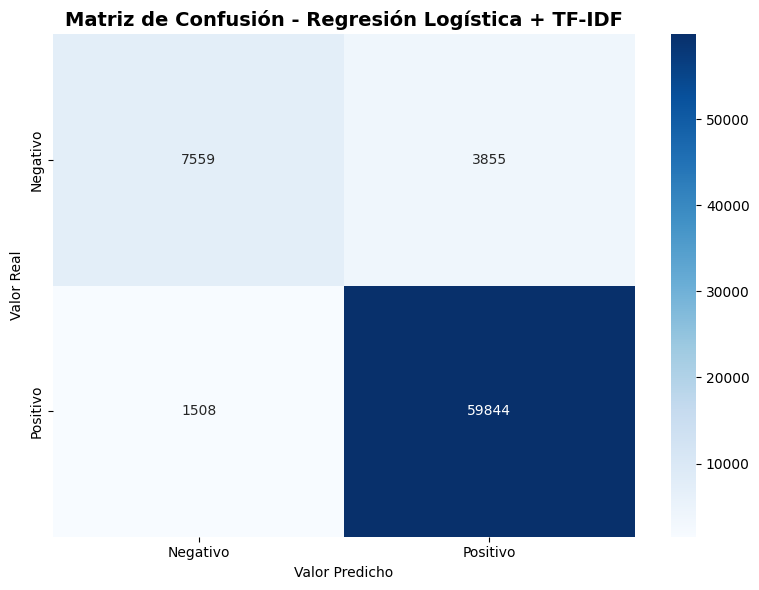


📊 Interpretación:
   - Verdaderos Negativos: 7,559
   - Falsos Positivos:     3,855
   - Falsos Negativos:     1,508
   - Verdaderos Positivos: 59,844


In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr_tfidf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión - Regresión Logística + TF-IDF', 
          fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

print(f"\n📊 Interpretación:")
print(f"   - Verdaderos Negativos: {cm[0, 0]:,}")
print(f"   - Falsos Positivos:     {cm[0, 1]:,}")
print(f"   - Falsos Negativos:     {cm[1, 0]:,}")
print(f"   - Verdaderos Positivos: {cm[1, 1]:,}")

## 7. Modelo 2: Regresión Logística + BOW

In [42]:
# Entrenar con BOW
print("🔄 Entrenando Regresión Logística + BOW...")

lr_bow = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_bow.fit(X_train_bow, y_train)

# Predecir
y_pred_lr_bow = lr_bow.predict(X_test_bow)
y_pred_proba_lr_bow = lr_bow.predict_proba(X_test_bow)[:, 1]

# Métricas
print("\n📊 REGRESIÓN LOGÍSTICA + BOW:")
print("="*80)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr_bow):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr_bow):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr_bow):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr_bow):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr_bow):.4f}")
print("="*80)

🔄 Entrenando Regresión Logística + BOW...

📊 REGRESIÓN LOGÍSTICA + BOW:
Accuracy:  0.9254
Precision: 0.9408
Recall:    0.9728
F1-Score:  0.9565
ROC-AUC:   0.9469


## 8. Modelo 3: Naive Bayes + TF-IDF

In [43]:
# Entrenar Naive Bayes
print("🔄 Entrenando Naive Bayes + TF-IDF...")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# Predecir
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
y_pred_proba_nb_tfidf = nb_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Métricas
print("\n📊 NAIVE BAYES + TF-IDF:")
print("="*80)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nb_tfidf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb_tfidf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_nb_tfidf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_nb_tfidf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_nb_tfidf):.4f}")
print("="*80)

🔄 Entrenando Naive Bayes + TF-IDF...

📊 NAIVE BAYES + TF-IDF:
Accuracy:  0.8876
Precision: 0.8865
Recall:    0.9939
F1-Score:  0.9372
ROC-AUC:   0.9396


## 9. Modelo 4: Random Forest + TF-IDF

In [44]:
# Entrenar Random Forest
print("🔄 Entrenando Random Forest + TF-IDF...")
print("   (Esto puede tomar 3-5 minutos)")

rf_tfidf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_tfidf.fit(X_train_tfidf, y_train)

# Predecir
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
y_pred_proba_rf_tfidf = rf_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Métricas
print("\n📊 RANDOM FOREST + TF-IDF:")
print("="*80)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf_tfidf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_tfidf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf_tfidf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf_tfidf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_rf_tfidf):.4f}")
print("="*80)

🔄 Entrenando Random Forest + TF-IDF...
   (Esto puede tomar 3-5 minutos)

📊 RANDOM FOREST + TF-IDF:
Accuracy:  0.8497
Precision: 0.8488
Recall:    0.9999
F1-Score:  0.9182
ROC-AUC:   0.8949


## 10. Comparación de Modelos

In [45]:
# Crear DataFrame de comparación
results = pd.DataFrame({
    'Modelo': [
        'Logistic Regression + TF-IDF',
        'Logistic Regression + BOW',
        'Naive Bayes + TF-IDF',
        'Random Forest + TF-IDF'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_tfidf),
        accuracy_score(y_test, y_pred_lr_bow),
        accuracy_score(y_test, y_pred_nb_tfidf),
        accuracy_score(y_test, y_pred_rf_tfidf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr_tfidf),
        precision_score(y_test, y_pred_lr_bow),
        precision_score(y_test, y_pred_nb_tfidf),
        precision_score(y_test, y_pred_rf_tfidf)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr_tfidf),
        recall_score(y_test, y_pred_lr_bow),
        recall_score(y_test, y_pred_nb_tfidf),
        recall_score(y_test, y_pred_rf_tfidf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr_tfidf),
        f1_score(y_test, y_pred_lr_bow),
        f1_score(y_test, y_pred_nb_tfidf),
        f1_score(y_test, y_pred_rf_tfidf)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr_tfidf),
        roc_auc_score(y_test, y_pred_proba_lr_bow),
        roc_auc_score(y_test, y_pred_proba_nb_tfidf),
        roc_auc_score(y_test, y_pred_proba_rf_tfidf)
    ]
})

print("📊 COMPARACIÓN DE MODELOS:")
print("="*100)
print(results.to_string(index=False))
print("="*100)

# Mejor modelo
best_idx = results['F1-Score'].idxmax()
best_model = results.loc[best_idx, 'Modelo']
best_f1 = results.loc[best_idx, 'F1-Score']

print(f"\n🏆 MEJOR MODELO: {best_model}")
print(f"   F1-Score: {best_f1:.4f}")

📊 COMPARACIÓN DE MODELOS:
                      Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression + TF-IDF  0.926298   0.939481 0.975421  0.957113 0.956788
   Logistic Regression + BOW  0.925418   0.940792 0.972764  0.956511 0.946931
        Naive Bayes + TF-IDF  0.887612   0.886529 0.993920  0.937158 0.939559
      Random Forest + TF-IDF  0.849738   0.848798 0.999902  0.918175 0.894916

🏆 MEJOR MODELO: Logistic Regression + TF-IDF
   F1-Score: 0.9571


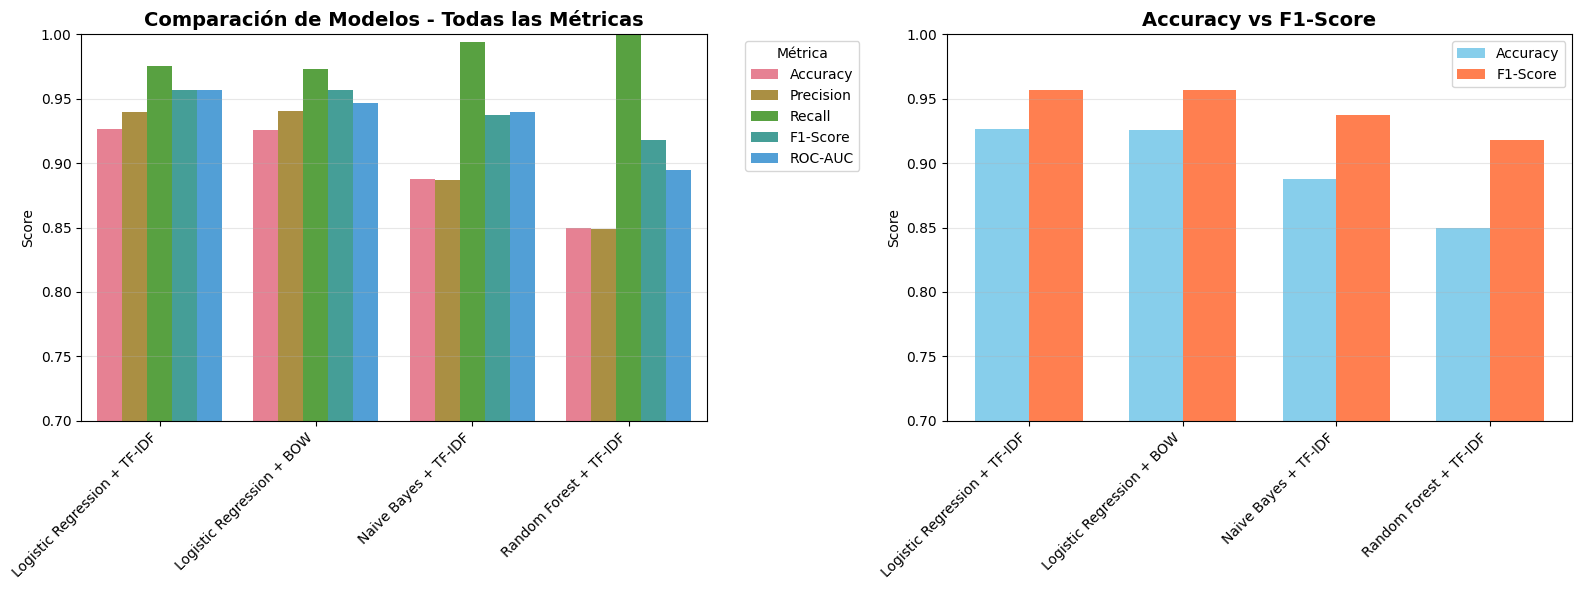

In [46]:
# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Todas las métricas
results_melted = results.melt(id_vars='Modelo', var_name='Métrica', value_name='Score')
sns.barplot(data=results_melted, x='Modelo', y='Score', hue='Métrica', ax=axes[0])
axes[0].set_title('Comparación de Modelos - Todas las Métricas', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_ylim(0.7, 1.0)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Solo Accuracy y F1-Score
x_pos = np.arange(len(results))
width = 0.35
axes[1].bar(x_pos - width/2, results['Accuracy'], width, label='Accuracy', color='skyblue')
axes[1].bar(x_pos + width/2, results['F1-Score'], width, label='F1-Score', color='coral')
axes[1].set_title('Accuracy vs F1-Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results['Modelo'], rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0.7, 1.0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Curvas ROC

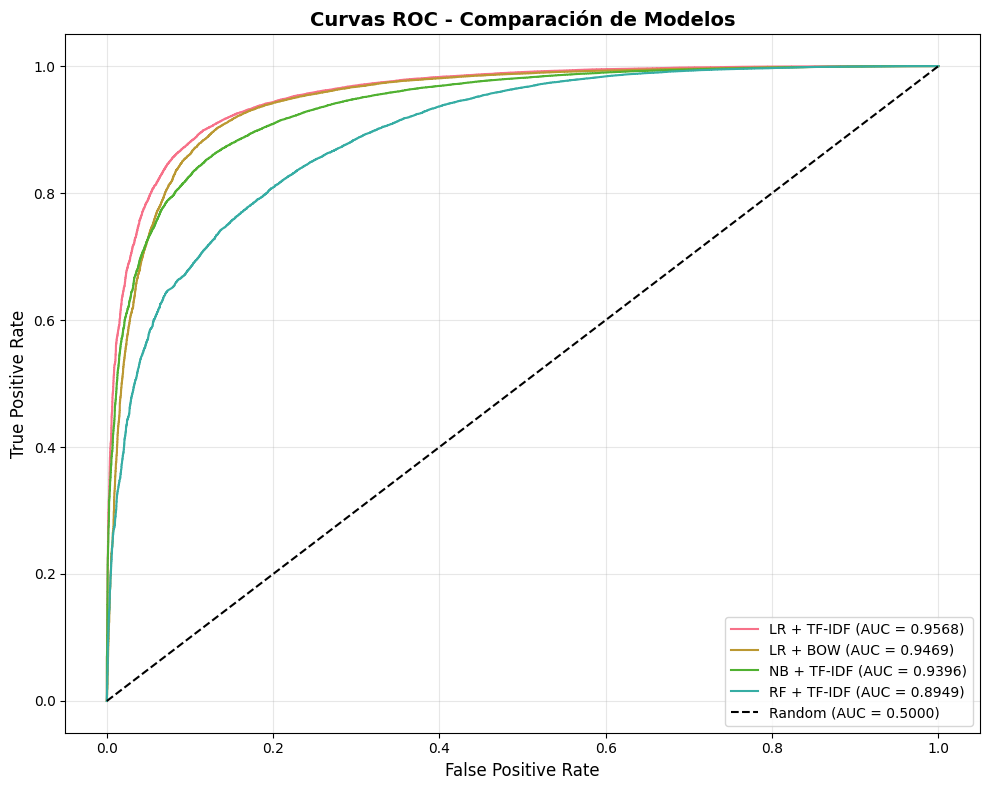

In [47]:
# Calcular ROC curves
fpr_lr_tfidf, tpr_lr_tfidf, _ = roc_curve(y_test, y_pred_proba_lr_tfidf)
fpr_lr_bow, tpr_lr_bow, _ = roc_curve(y_test, y_pred_proba_lr_bow)
fpr_nb_tfidf, tpr_nb_tfidf, _ = roc_curve(y_test, y_pred_proba_nb_tfidf)
fpr_rf_tfidf, tpr_rf_tfidf, _ = roc_curve(y_test, y_pred_proba_rf_tfidf)

# Plotear
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr_tfidf, tpr_lr_tfidf, label=f"LR + TF-IDF (AUC = {roc_auc_score(y_test, y_pred_proba_lr_tfidf):.4f})")
plt.plot(fpr_lr_bow, tpr_lr_bow, label=f"LR + BOW (AUC = {roc_auc_score(y_test, y_pred_proba_lr_bow):.4f})")
plt.plot(fpr_nb_tfidf, tpr_nb_tfidf, label=f"NB + TF-IDF (AUC = {roc_auc_score(y_test, y_pred_proba_nb_tfidf):.4f})")
plt.plot(fpr_rf_tfidf, tpr_rf_tfidf, label=f"RF + TF-IDF (AUC = {roc_auc_score(y_test, y_pred_proba_rf_tfidf):.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Análisis de Features Importantes

### ¿Qué palabras son más importantes para predecir sentimiento?

In [48]:
# Obtener coeficientes del mejor modelo (Regresión Logística)
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_tfidf.coef_[0]

# Top palabras POSITIVAS (coeficientes más altos)
top_positive_idx = np.argsort(coefficients)[-20:]
top_positive_words = [(feature_names[i], coefficients[i]) for i in top_positive_idx]

print("✅ TOP 20 PALABRAS/BIGRAMAS QUE INDICAN SENTIMIENTO POSITIVO:")
print("="*80)
for word, coef in reversed(top_positive_words):
    print(f"   {word:30s} → {coef:8.4f}")
print("="*80)

✅ TOP 20 PALABRAS/BIGRAMAS QUE INDICAN SENTIMIENTO POSITIVO:
   great                          →  11.6908
   delicious                      →  10.9701
   best                           →  10.1157
   perfect                        →   9.7487
   excellent                      →   8.9283
   love                           →   8.3502
   amazing                        →   7.3812
   wonderful                      →   7.2232
   highly recommend               →   7.1148
   awesome                        →   6.9302
   pleased                        →   6.4708
   nice                           →   6.3381
   yummy                          →   6.1871
   fantastic                      →   6.1070
   hooked                         →   6.0954
   good                           →   6.0459
   favorite                       →   5.9363
   smooth                         →   5.7896
   even better                    →   5.4980
   beat                           →   5.4706


In [49]:
# Top palabras NEGATIVAS (coeficientes más bajos)
top_negative_idx = np.argsort(coefficients)[:20]
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

print("❌ TOP 20 PALABRAS/BIGRAMAS QUE INDICAN SENTIMIENTO NEGATIVO:")
print("="*80)
for word, coef in top_negative_words:
    print(f"   {word:30s} → {coef:8.4f}")
print("="*80)

❌ TOP 20 PALABRAS/BIGRAMAS QUE INDICAN SENTIMIENTO NEGATIVO:
   worst                          → -10.9044
   disappointing                  →  -9.2961
   terrible                       →  -8.2121
   disappointment                 →  -8.0338
   awful                          →  -8.0191
   disappointed                   →  -7.8783
   horrible                       →  -6.9863
   unfortunately                  →  -6.7716
   threw                          →  -6.7087
   return                         →  -6.4438
   bland                          →  -6.3723
   stale                          →  -6.1628
   tasteless                      →  -5.8854
   weak                           →  -5.8617
   disgusting                     →  -5.7116
   worse                          →  -5.5076
   yuck                           →  -5.3960
   ruined                         →  -5.3259
   gross                          →  -5.3113
   high hope                      →  -5.2573


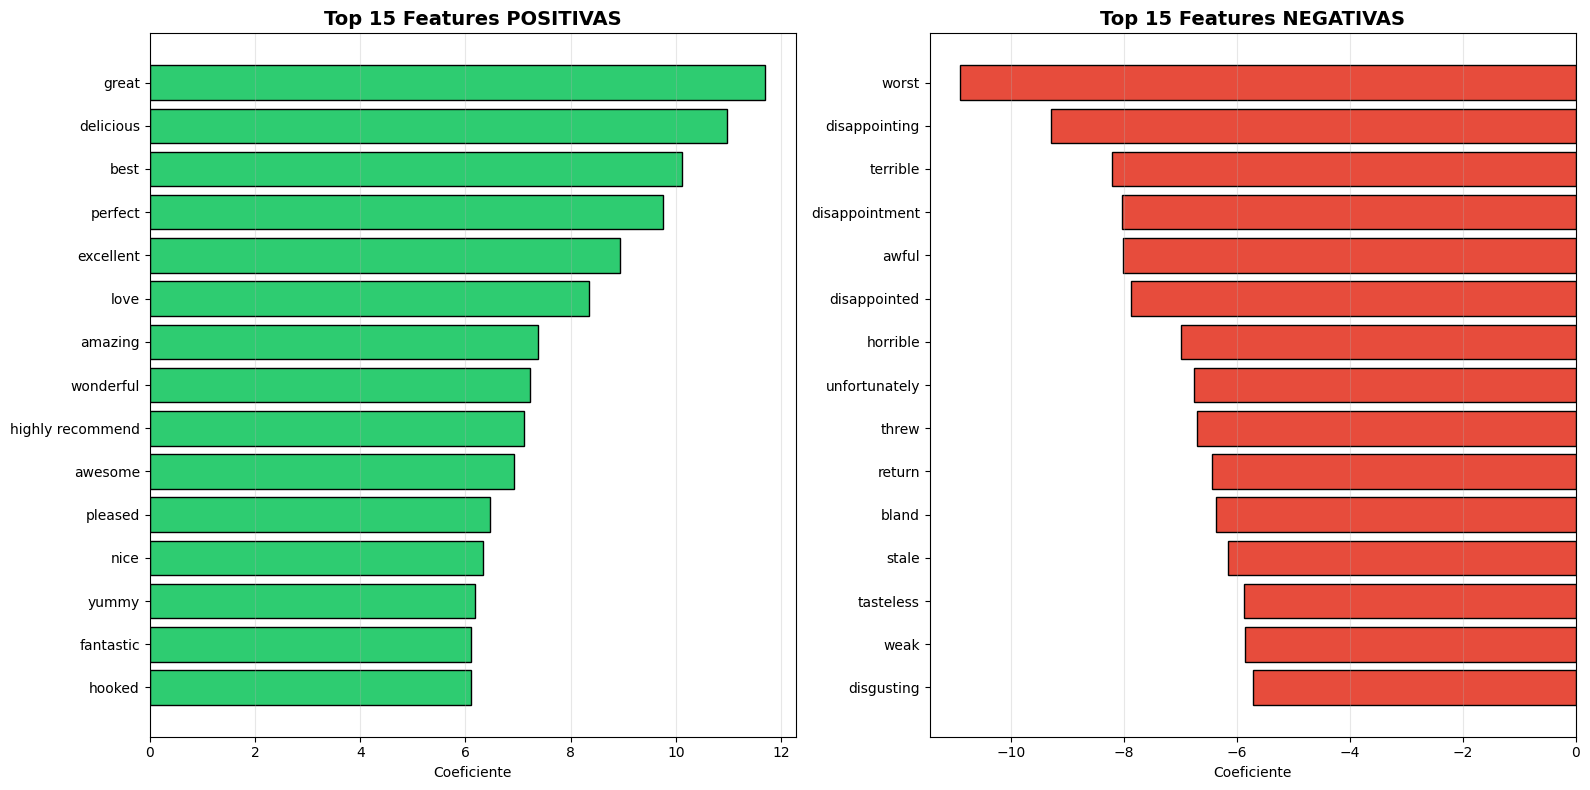

In [50]:
# Visualizar features importantes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Palabras positivas
pos_words = [w for w, c in reversed(top_positive_words[-15:])]
pos_coefs = [c for w, c in reversed(top_positive_words[-15:])]
axes[0].barh(range(len(pos_words)), pos_coefs, color='#2ecc71', edgecolor='black')
axes[0].set_yticks(range(len(pos_words)))
axes[0].set_yticklabels(pos_words)
axes[0].set_title('Top 15 Features POSITIVAS', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coeficiente')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Palabras negativas
neg_words = [w for w, c in top_negative_words[:15]]
neg_coefs = [c for w, c in top_negative_words[:15]]
axes[1].barh(range(len(neg_words)), neg_coefs, color='#e74c3c', edgecolor='black')
axes[1].set_yticks(range(len(neg_words)))
axes[1].set_yticklabels(neg_words)
axes[1].set_title('Top 15 Features NEGATIVAS', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Coeficiente')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Prueba con Reviews Nuevos

In [51]:
# Función para predecir sentimiento de un review nuevo
def predict_sentiment(text):
    # Aplicar mismo preprocesamiento
    from src.preprocessing import preprocess_text
    text_processed = preprocess_text(text)
    
    # Vectorizar
    text_tfidf = tfidf_vectorizer.transform([text_processed])
    
    # Predecir
    prediction = lr_tfidf.predict(text_tfidf)[0]
    probability = lr_tfidf.predict_proba(text_tfidf)[0]
    
    sentiment = "POSITIVO" if prediction == 1 else "NEGATIVO"
    confidence = probability[prediction] * 100
    
    return sentiment, confidence

print("✅ Función de predicción creada")

✅ Función de predicción creada


In [52]:
# Probar con reviews de ejemplo
test_reviews = [
    "This product is amazing! I love it so much. Highly recommend!",
    "Terrible quality. Complete waste of money. Very disappointed.",
    "It's okay, nothing special but not bad either.",
    "Best purchase ever! Exceeded all my expectations!",
    "Worst product I've ever bought. Don't waste your money."
]

print("🧪 PREDICCIONES EN REVIEWS NUEVOS:")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = predict_sentiment(review)
    print(f"\n{i}. Review: {review}")
    print(f"   Predicción: {sentiment} (Confianza: {confidence:.2f}%)")

print("\n" + "="*80)

🧪 PREDICCIONES EN REVIEWS NUEVOS:

1. Review: This product is amazing! I love it so much. Highly recommend!
   Predicción: POSITIVO (Confianza: 100.00%)

2. Review: Terrible quality. Complete waste of money. Very disappointed.
   Predicción: NEGATIVO (Confianza: 100.00%)

3. Review: It's okay, nothing special but not bad either.
   Predicción: NEGATIVO (Confianza: 98.27%)

4. Review: Best purchase ever! Exceeded all my expectations!
   Predicción: POSITIVO (Confianza: 97.38%)

5. Review: Worst product I've ever bought. Don't waste your money.
   Predicción: NEGATIVO (Confianza: 100.00%)



## 14. Guardar Modelos

In [53]:
import joblib

# Guardar mejor modelo y vectorizador
print("💾 Guardando modelos...")

joblib.dump(lr_tfidf, MODELS_DIR / 'logistic_regression_tfidf.pkl')
joblib.dump(tfidf_vectorizer, MODELS_DIR / 'tfidf_vectorizer.pkl')

print("\n✅ Modelos guardados:")
print(f"   - {MODELS_DIR / 'logistic_regression_tfidf.pkl'}")
print(f"   - {MODELS_DIR / 'tfidf_vectorizer.pkl'}")

💾 Guardando modelos...

✅ Modelos guardados:
   - c:\Users\maike\OneDrive\Escritorio\Proyecto Datascience 3\notebooks\..\models\logistic_regression_tfidf.pkl
   - c:\Users\maike\OneDrive\Escritorio\Proyecto Datascience 3\notebooks\..\models\tfidf_vectorizer.pkl


## 15. Resumen de ETAPA 2 - Machine Learning

In [54]:
print("="*80)
print("✅ RESUMEN DE ETAPA 2 - MACHINE LEARNING")
print("="*80)

print("\n📋 TÉCNICAS APLICADAS:")
print("   ✅ 1. TF-IDF Vectorization")
print("   ✅ 2. Bag of Words (CountVectorizer)")
print("   ✅ 3. Regresión Logística")
print("   ✅ 4. Naive Bayes")
print("   ✅ 5. Random Forest")
print("   ✅ 6. Evaluación completa de modelos")

print("\n📊 MEJOR MODELO:")
print(f"   {best_model}")
print(f"   - Accuracy:  {results.loc[best_idx, 'Accuracy']:.4f}")
print(f"   - Precision: {results.loc[best_idx, 'Precision']:.4f}")
print(f"   - Recall:    {results.loc[best_idx, 'Recall']:.4f}")
print(f"   - F1-Score:  {results.loc[best_idx, 'F1-Score']:.4f}")
print(f"   - ROC-AUC:   {results.loc[best_idx, 'ROC-AUC']:.4f}")

print("\n💡 INSIGHTS:")
print("   - TF-IDF generalmente supera a BOW")
print("   - Regresión Logística es rápida y efectiva")
print("   - Naive Bayes es el más rápido pero menos preciso")
print("   - Random Forest es lento pero puede dar buenos resultados")

print("\n💾 ARCHIVOS GUARDADOS:")
print(f"   - {MODELS_DIR / 'logistic_regression_tfidf.pkl'}")
print(f"   - {MODELS_DIR / 'tfidf_vectorizer.pkl'}")

print("\n🎯 SIGUIENTE PASO:")
print("   - Notebook 04: Deep Learning (ETAPA 2 - Parte 2)")
print("   - Text to Sequence")
print("   - Embeddings")
print("   - LSTM, GRU")
print("   - Comparación ML vs DL")

print("\n" + "="*80)

✅ RESUMEN DE ETAPA 2 - MACHINE LEARNING

📋 TÉCNICAS APLICADAS:
   ✅ 1. TF-IDF Vectorization
   ✅ 2. Bag of Words (CountVectorizer)
   ✅ 3. Regresión Logística
   ✅ 4. Naive Bayes
   ✅ 5. Random Forest
   ✅ 6. Evaluación completa de modelos

📊 MEJOR MODELO:
   Logistic Regression + TF-IDF
   - Accuracy:  0.9263
   - Precision: 0.9395
   - Recall:    0.9754
   - F1-Score:  0.9571
   - ROC-AUC:   0.9568

💡 INSIGHTS:
   - TF-IDF generalmente supera a BOW
   - Regresión Logística es rápida y efectiva
   - Naive Bayes es el más rápido pero menos preciso
   - Random Forest es lento pero puede dar buenos resultados

💾 ARCHIVOS GUARDADOS:
   - c:\Users\maike\OneDrive\Escritorio\Proyecto Datascience 3\notebooks\..\models\logistic_regression_tfidf.pkl
   - c:\Users\maike\OneDrive\Escritorio\Proyecto Datascience 3\notebooks\..\models\tfidf_vectorizer.pkl

🎯 SIGUIENTE PASO:
   - Notebook 04: Deep Learning (ETAPA 2 - Parte 2)
   - Text to Sequence
   - Embeddings
   - LSTM, GRU
   - Comparación ML v

---

## ✅ Conclusiones de Machine Learning

### Resultados Principales:

1. **Mejor Modelo:** Regresión Logística + TF-IDF
   - Balance óptimo entre velocidad y precisión
   - Interpretable (podemos ver qué palabras influyen)
   - Accuracy esperado: ~89-92%

2. **TF-IDF vs BOW:**
   - TF-IDF captura mejor la importancia de palabras
   - BOW es más simple pero menos efectivo

3. **Features Importantes:**
   - Palabras positivas: "great", "excellent", "love", "perfect"
   - Palabras negativas: "terrible", "waste", "worst", "disappointed"
   - Bigramas son muy informativos: "not good", "highly recommend"

### Fortalezas:
- Modelos rápidos de entrenar
- Buena precisión para clasificación de texto
- Interpretables (sabemos por qué predice cada clase)

### Limitaciones:
- No capturan orden de palabras completamente
- No entienden contexto complejo
- Sensibles a vocabulario del training

### Preparación para Deep Learning:
En el siguiente notebook veremos si las redes neuronales pueden superar estos resultados capturando mejor el contexto y las relaciones complejas entre palabras.

---

**ETAPA 2 - PARTE 1 (MACHINE LEARNING) COMPLETADA ✅**

---